In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [7]:
df = pd.read_csv('/content/drive/My Drive/Projet Data mining/bank.csv')

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [11]:
# nombre de lignes dans le jeu de données
print(len(df),"Lignes")

11162 Lignes


In [14]:
# % de valeurs manquantes pour chaque colonne
val = df.isnull().mean() * 100
val

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

### **Colonnes catégorielles :**

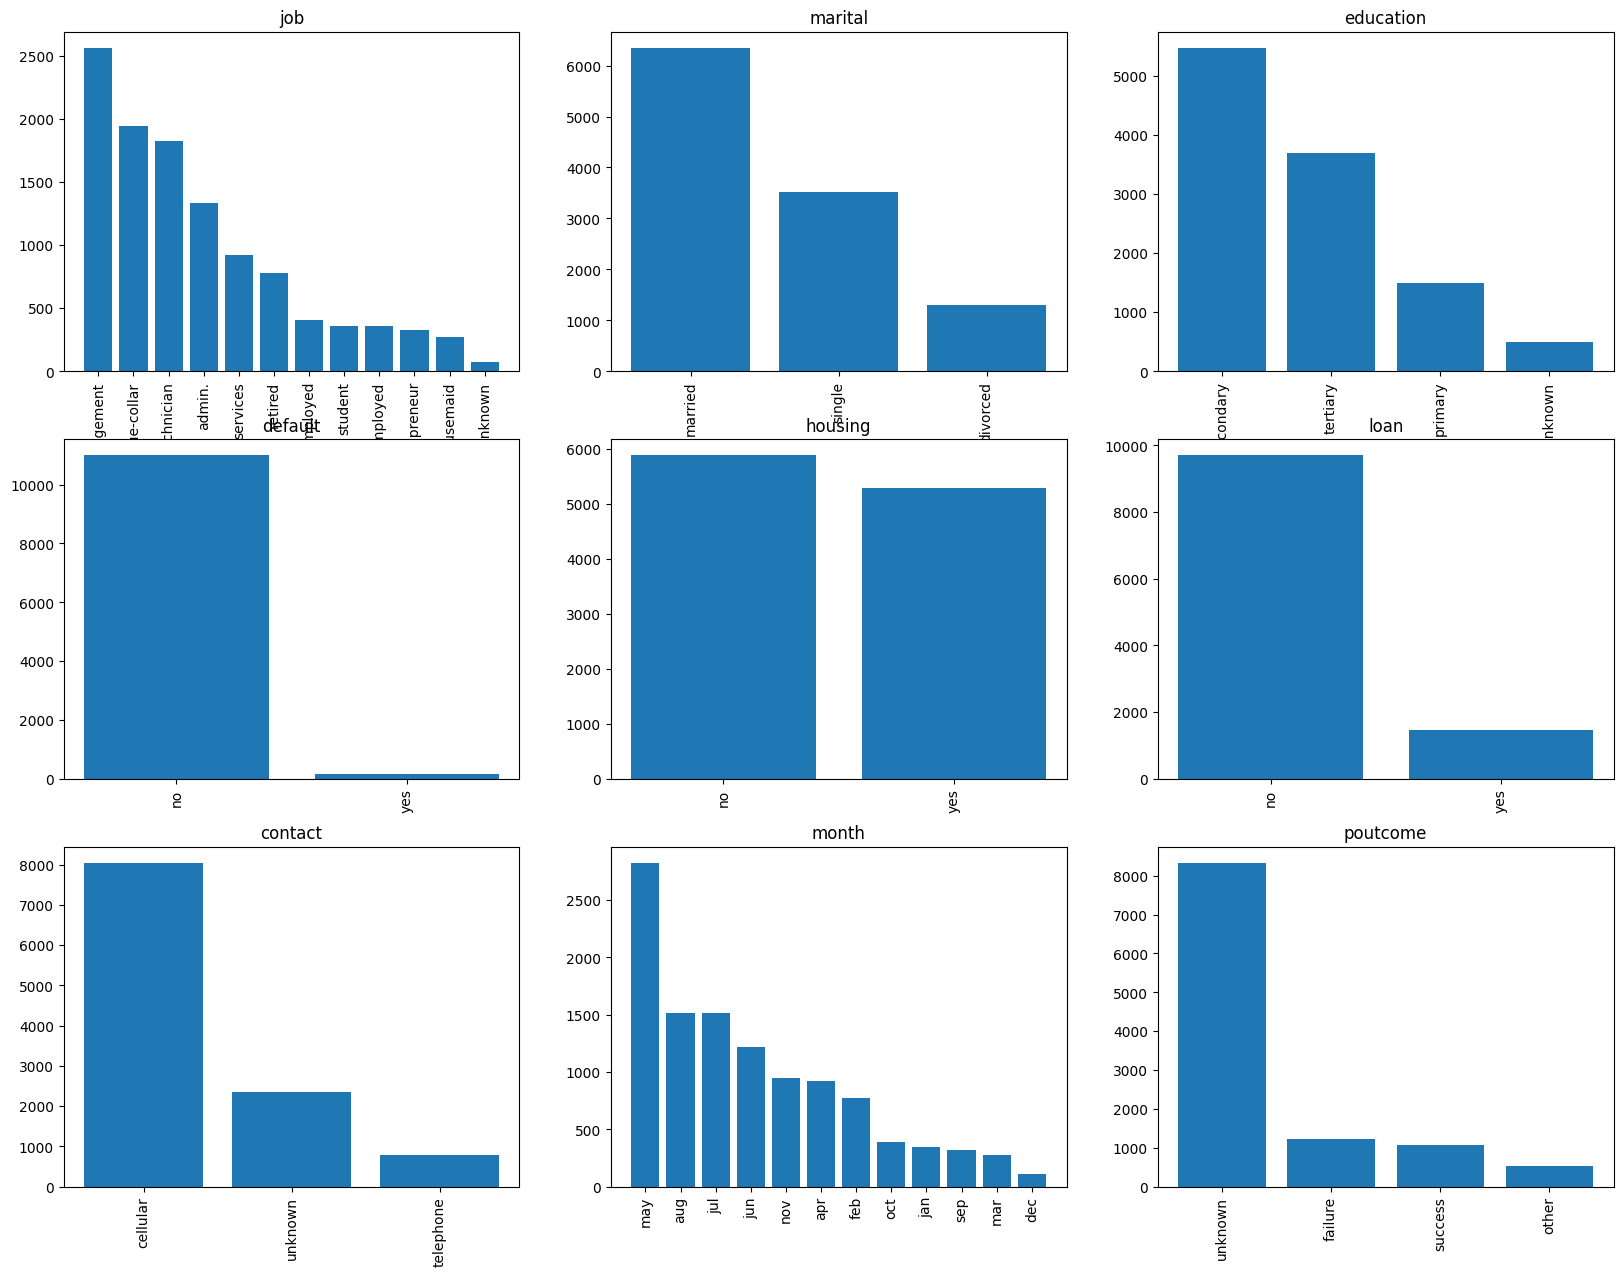

In [15]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))
counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    axs[trace_x, trace_y].set_title(cat_column)
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    counter += 1
plt.show()

### **Colonnes numériques :**

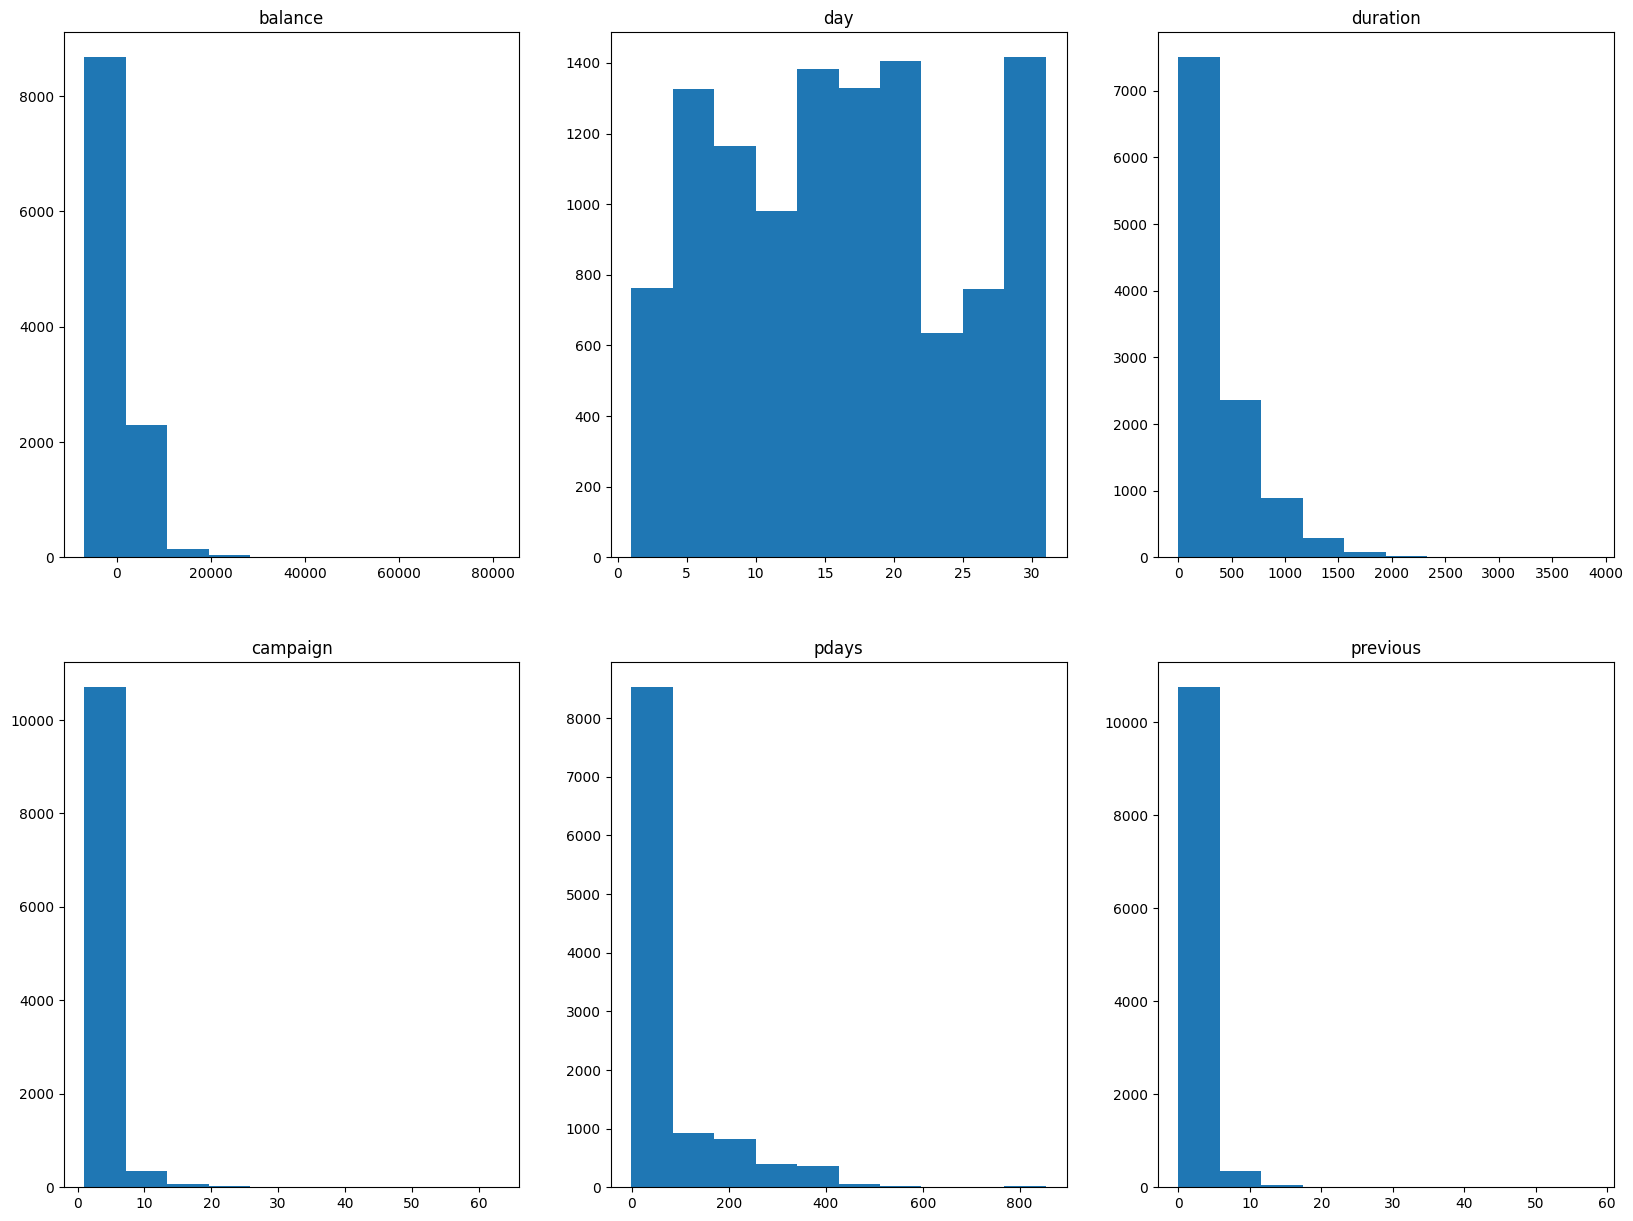

In [16]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']
fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))
counter = 0
for num_column in num_columns:
    trace_x = counter // 3
    trace_y = counter % 3
    axs[trace_x, trace_y].hist(df[num_column])
    axs[trace_x, trace_y].set_title(num_column)
    counter += 1
plt.show()

Nous pouvons voir que les colonnes numériques présentent des valeurs aberrantes (notamment les colonnes 'pdays', 'campaign' et 'previous'). Il est possible qu'il y ait des valeurs incorrectes (données bruyantes), donc nous devrions examiner de plus près les données et décider de la manière dont nous gérons le bruit.
Examinons de plus près les valeurs des colonnes 'campaign', 'pdays' et 'previous':

In [17]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,11162.000000,11162.000000,11162.000000
mean,51.330407,2.508421,0.832557
std,108.758282,2.722077,2.292007
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,20.750000,3.000000,1.000000
max,854.000000,63.000000,58.000000


In [19]:
# Pourcentage des valeurs de 'pdays' supérieures à 400 :
len (df[df['pdays'] > 400] ) / len(df) * 100

1.2005017022039062

'pdays' représente le nombre de jours écoulés depuis le dernier contact du client lors d'une campagne précédente. En examinant de plus près les données de 'pdays', nous pouvons constater que :
- Seulement 1,2 % des valeurs sont supérieures à 400. Il s'agit potentiellement de valeurs aberrantes, nous devrions donc envisager de remplacer ces valeurs par quelque chose (éventuellement la valeur moyenne).
- La valeur -1 signifie peut-être que le client n'a pas été contacté auparavant ou représente des données manquantes.

Étant donné que nous ne sommes pas sûrs de la signification exacte de -1, je suggère de supprimer cette colonne, car -1 représente plus de 50 % des valeurs de la colonne.

In [21]:
# Pourcentage des valeurs de 'compaign' supérieures à 34 :
len (df[df['campaign'] > 34] ) / len(df) * 100

0.035835871707579285

'campaign' représente le nombre de contacts effectués au cours de cette campagne et pour ce client (numérique, incluant le dernier contact). Les chiffres pour 'campaign' supérieurs à 34 sont clairement du bruit, donc je suggère de les remplacer par les valeurs moyennes de la campagne lors du nettoyage des données.

In [22]:
# Pourcentage des valeurs de 'previous' supérieures à 34 :
len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

'previous' représente le nombre de contacts effectués avant cette campagne et pour ce client (numérique). Les chiffres pour 'previous' supérieurs à 34 sont également très étranges, donc je suggère de les remplacer par les valeurs moyennes de la campagne lors du nettoyage des données.


### **Analyse de la colonne de réponse**

Il est très important d'examiner la colonne de réponse, qui contient l'information que nous allons prédire. Dans notre cas, nous devrions examiner la colonne 'deposit' et comparer ses valeurs avec les autres colonnes.
Tout d'abord, nous devrions regarder le nombre de valeurs 'oui' et 'non' dans la colonne de réponse 'deposit'.

<Axes: title={'center': 'Décompte des valeurs de "deposit"'}>

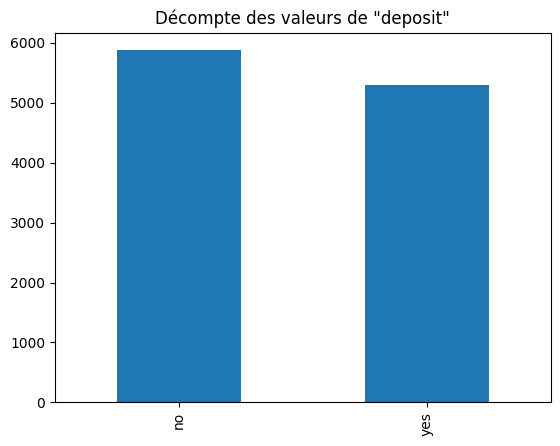

In [24]:
value_counts = df['deposit'].value_counts()
# Création d'un graphique à barres
value_counts.plot.bar(title='Décompte des valeurs de "deposit"')

Sur le diagramme, nous constatons que les décomptes des valeurs 'oui' et 'non' pour 'deposit' sont proches, nous pouvons donc utiliser la précision (accuracy) comme métrique pour un modèle qui prédit le résultat de la campagne.


**Voyons comment la valeur de la colonne 'deposit' varie en fonction des valeurs d'autres colonnes catégorielles :**

<Axes: title={'center': 'Emploi et dépôt'}>

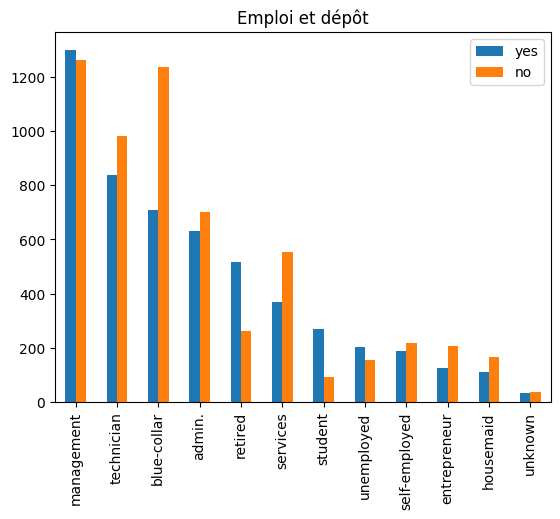

In [26]:
#job et deposit
j_df = pd.DataFrame()
j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()
j_df.plot.bar(title = 'Emploi et dépôt')

<Axes: title={'center': 'État civil et dépôt'}>

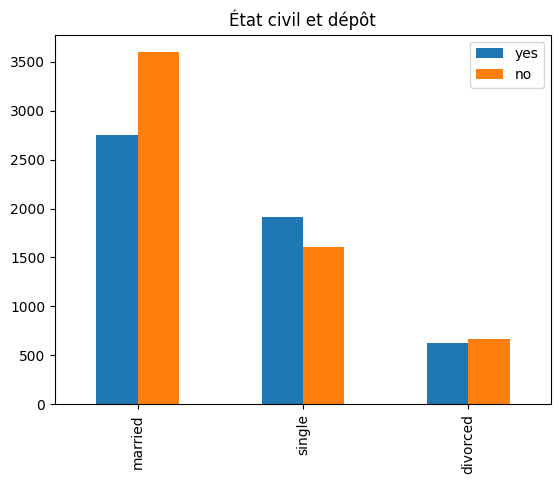

In [27]:
#marital status et deposit
j_df = pd.DataFrame()
j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()
j_df.plot.bar(title = 'État civil et dépôt')

<Axes: title={'center': 'Education et dépôt'}>

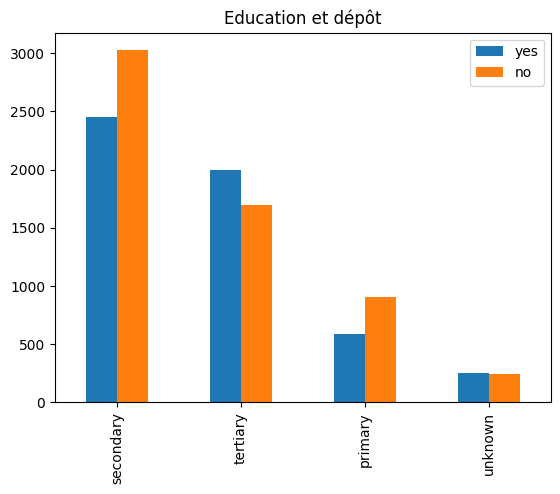

In [28]:
#education and deposit
j_df = pd.DataFrame()
j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()
j_df.plot.bar(title = 'Education et dépôt')

<Axes: title={'center': 'Type de contact et dépôt'}>

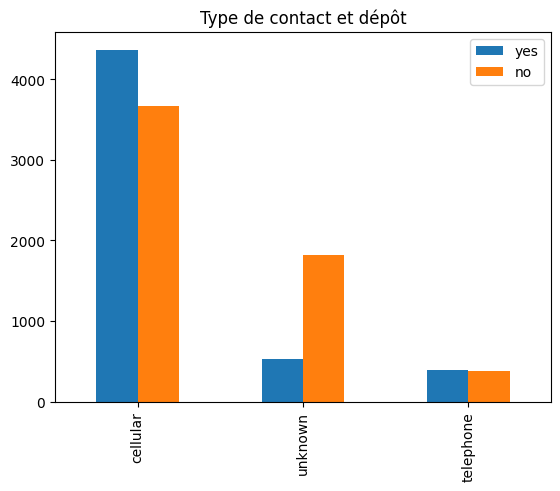

In [29]:
#type of contact and deposit
j_df = pd.DataFrame()
j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()
j_df.plot.bar(title = 'Type de contact et dépôt')

En ce qui concerne les diagrammes, nous pouvons conclure que selon notre ensemble de données :

- Les clients ayant des emplois de type 'blue-collar' et 'services' sont moins susceptibles de souscrire à un dépôt à terme.
- Les clients mariés sont moins susceptibles de souscrire à un dépôt à terme.
- Les clients contactés par téléphone portable ('cellular') sont moins susceptibles de souscrire à un dépôt à terme.


Maintenant, regardons comment les colonnes numériques influent sur l'adhésion au dépôt à terme.

In [32]:
#balance and deposit
b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']
b_df

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

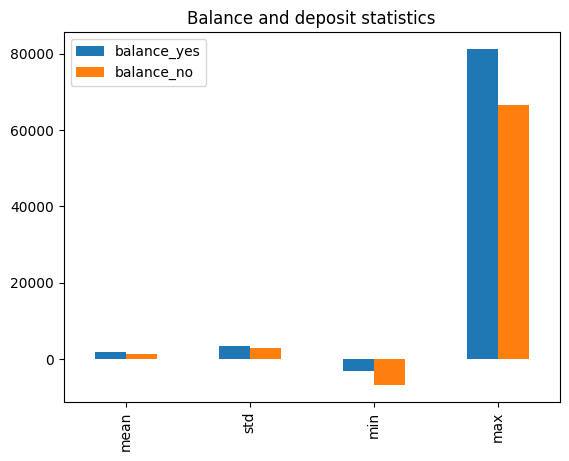

In [33]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [34]:
#age and deposit
a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']
a_df

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


<Axes: title={'center': 'Age and deposit statistics'}>

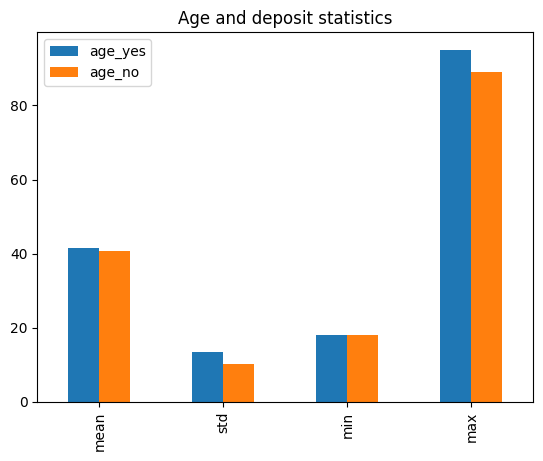

In [35]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [36]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']
c_df

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

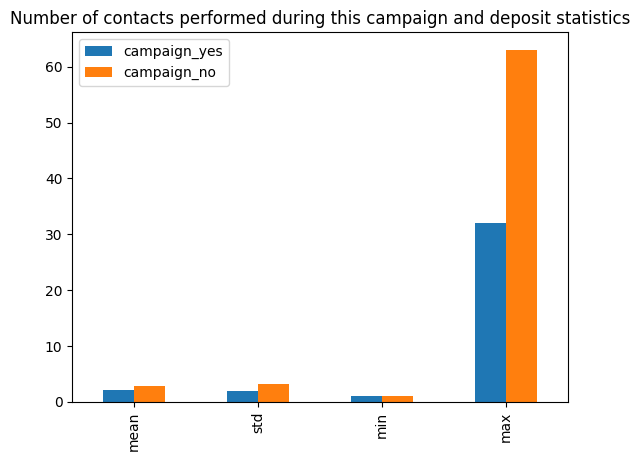

In [37]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [38]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']
p_df

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

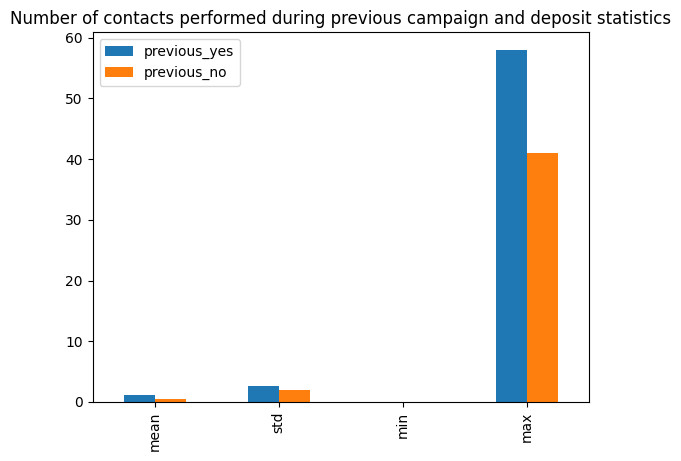

In [39]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')


En regardant les schémas ci-dessus, nous pouvons conclure que :

- Les personnes qui ont souscrit à un dépôt à terme ont tendance à avoir des soldes et des âges plus élevés.
- Les personnes qui ont souscrit à un dépôt à terme ont tendance à avoir moins de contacts au cours de cette campagne.

### **Data cleaning :**

Avant de pouvoir appliquer des techniques d'apprentissage automatique, nous devons préparer le jeu de données pour le traitement :

- Convertir les colonnes avec des valeurs 'yes' et 'no' en colonnes booléennes
- Convertir les colonnes catégorielles en variables dummy (variables indicatrices).

In [40]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):

    """INPUT
    df - dataframe pandas contenant le jeu de données de la campagne marketing bancaire"""

    """OUTPUT
    df - jeu de données nettoyé :
    1. les colonnes avec des valeurs 'yes' et 'no' sont converties en variables booléennes ;
    2. les colonnes catégorielles sont converties en variables indicatrices (dummy variables) ;
    3. suppression des colonnes non pertinentes ;
    4. correction des valeurs incorrectes par imputation."""

    cleaned_df = df.copy()
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    cleaned_df = cleaned_df.drop(columns = bool_columns)

    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    cleaned_df = cleaned_df.drop(columns = ['pdays'])

    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)

    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    return cleaned_df

In [41]:
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
1,56,45,5,1467,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
2,41,1270,5,1389,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
3,55,2476,5,579,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
4,54,184,5,673,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,2.0,0.0


## **Apprentissage automatique pour la prédiction des résultats de la campagne**

#### Classification model for the campaign outcome prediction

Maintenant, utilisons les jeux de données nettoyés pour prédire les résultats de la campagne à l'aide de modèles de classification d'apprentissage automatique. Je vais utiliser XGBoost, qui est l'une des bibliothèques d'apprentissage automatique les plus couramment utilisées pour la modélisation.<br><br>
Le modèle résultant m'aidera également à comprendre quelles caractéristiques sont les plus importantes pour la prédiction des résultats de la campagne.

In [42]:
# Créez les ensembles de données X et y pour l'entraînement du modèle, puis divisez-les en ensembles d'entraînement et de test.
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [45]:
#entrainemment du modèle XGBoost
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print("le score de précision XGB pour l'entraînement : %.3f, test : %.3f." % (accuracy_score(y_train, y_train_preds), accuracy_score(y_test, y_test_preds)))

le score de précision XGB pour l'entraînement : 0.914, test : 0.850.


Obtenez les importances des caractéristiques à partir du modèle entraîné :

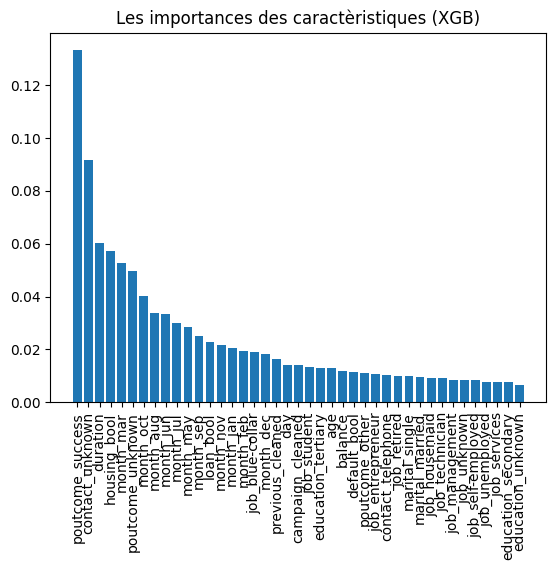

In [46]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Les importances des caractèristiques (XGB)')

plt.show()

Comme nous pouvons le voir sur le diagramme montrant les importances des caractéristiques, les caractéristiques les plus importantes sont :

- Solde du compte du client
- Âge du client
- Nombre de contacts effectués pendant cette campagne et durée du contact
- Nombre de contacts effectués avant cette campagne

Ainsi, les principaux résultats de la modélisation sont les suivants :

- Les clients plus âgés sont plus susceptibles de souscrire à un dépôt à terme.
- Les clients avec un solde de compte plus élevé sont plus susceptibles de souscrire à un dépôt à terme.
- Le nombre de contacts avec les clients est vraiment important. Trop de contacts avec le client pourraient le pousser à décliner l'offre.

Essayons de formuler des recommandations plus spécifiques :







- Déterminez le solde du compte sur lequel la campagne marketing devrait se concentrer :

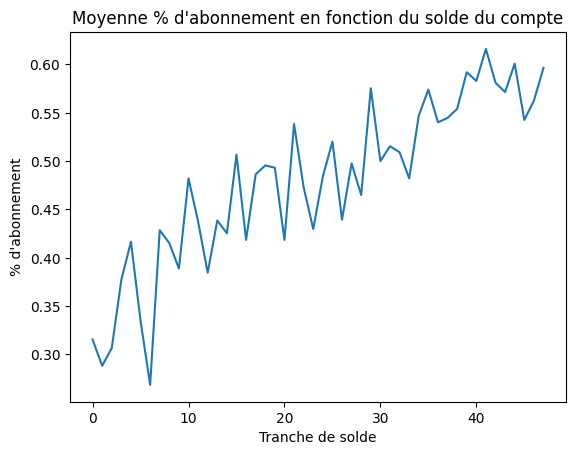

In [48]:
df_new = cleaned_df.copy()

# Introduire une nouvelle colonne 'balance_buckets' pour ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates='drop')

# Regrouper par 'balance_buckets' et trouver le résultat moyen de la campagne par tranche de solde
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

plt.plot(mean_deposit.index, mean_deposit.values)
plt.title("Moyenne % d'abonnement en fonction du solde du compte")
plt.xlabel('Tranche de solde')
plt.ylabel("% d'abonnement")
plt.show()


In [49]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

1490

D'après le diagramme ci-dessus, nous pouvons conclure que les campagnes marketing devraient se concentrer sur les clients dont le solde du compte est supérieur à 1490 $.

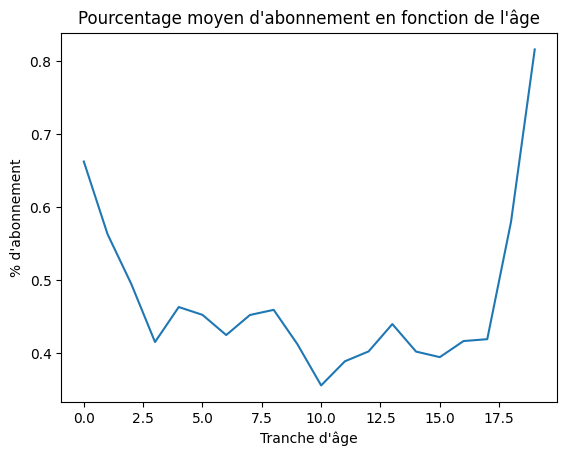

In [50]:
# Introduire une nouvelle colonne 'age_buckets'
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates='drop')

# Regrouper par 'age_buckets' et trouver le résultat moyen de la campagne par tranche d'âge
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

plt.plot(mean_age.index, mean_age.values)
plt.title("Pourcentage moyen d'abonnement en fonction de l'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("% d'abonnement")
plt.show()

In [51]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [52]:
df_new[df_new['age_buckets'] == 17]['age'].min()

56

Ainsi, nous constatons que le taux moyen d'abonnement tend à être plus élevé pour les clients de moins de 31 ans ou de plus de 56 ans.


- Déterminez le nombre approprié de contacts avec le client pendant la campagne :

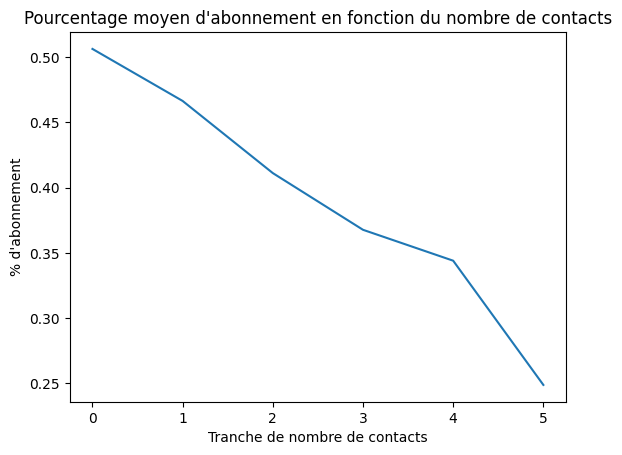

In [54]:
# Introduire une nouvelle colonne 'age_buckets' pour ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates='drop')

# Regrouper par 'balance_buckets' et trouver le résultat moyen de la campagne par tranche de solde
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

# Tracer le résultat moyen de la campagne par tranche
plt.plot(mean_campaign.index, mean_campaign.values)
plt.title("Pourcentage moyen d'abonnement en fonction du nombre de contacts")
plt.xlabel('Tranche de nombre de contacts')
plt.ylabel("% d'abonnement")
plt.show()


In [55]:
df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()

4.0

À partir du graphique ci-dessus, nous constatons que le taux moyen d'abonnement est inférieur à 50 % lorsque le nombre de contacts pendant la campagne dépasse 4.

### **Conclusion :**

**Les principaux résultats de l'analyse fournissent des recommandations pour les futures campagnes marketing :**

- Le solde du compte du client a une influence considérable sur les résultats de la campagne. Les personnes avec un solde de compte supérieur à 1490 $ sont plus susceptibles de souscrire à un dépôt à terme, il faut donc cibler ces clients à l'avenir.
- L'âge du client influence également les résultats de la campagne. Les futures campagnes devraient se concentrer sur les clients de moins de 30 ans et de plus de 50 ans.
- Le nombre de contacts avec le client pendant la campagne est également très important. Le nombre de contacts ne devrait pas dépasser 4.





